In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(np.float32)

In [4]:
inputs = Input(shape=(28,28,1))
x = Conv2D(4, 3, bias_initializer='random_normal')(inputs)
model = Model(inputs, x)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [6]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    print(input_value)
    yield [input_value]

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter._experimental_disable_per_channel = True
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpfc4k8q3_/assets


INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpfc4k8q3_/assets
/Users/sty/miniforge3/envs/tf-cpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-08 20:14:47.138975: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-08 20:14:47.139121: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-08 20:14:47.140030: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpfc4k8q3_
2022-12-08 20:14:47.140361: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-08 20:14:47.140366: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info 

tf.Tensor(
[[[[  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]]

  [[  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]]

  [[  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]]

  [[  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   

fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [8]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

'''
This gives a list of dictionaries. 
'''
tensor_details = tflite_interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization'][0]
    zero_points = dict['quantization'][1]
    tensor = tflite_interpreter.tensor(i)()

    #print(i, type, tensor_name, scales.shape, zero_points.shape, tensor.shape)
    print(dict)
    if "Conv2D" in tensor_name:
        weights = tensor
        scale = scales
        print(tensor)
    if "Bias" in tensor_name:
        biases = tensor
        print(tensor)

== Input details ==
name: serving_default_input_1:0
shape: [ 1 28 28  1]
type: <class 'numpy.int8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 26 26  4]
type: <class 'numpy.int8'>
{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, -128), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'model/conv2d/BiasAdd/ReadVariableOp', 'index': 1, 'shape': array([4], dtype=int32), 'shape_signature': array([4], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.002863671164959669, 0), 'quantization_parameters': {'scales': array([0.00286367], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
[-19   1  15   9]
{'name': 'model/conv2d

INFO: Initialized TensorFlow Lite runtime.


In [9]:
A = (np.rollaxis(weights, 0,4)*scale)
A

array([[[[-0.06013709, -0.13459254,  0.33218586, -0.35509522]],

        [[-0.24627572,  0.32645851, -0.10022849, -0.0400914 ]],

        [[ 0.07445545,  0.18613863, -0.18327495,  0.20332065]]],


       [[[ 0.1088195 , -0.18041128, -0.06586444,  0.00286367]],

        [[ 0.32359484,  0.15177457, -0.07731912,  0.2577304 ]],

        [[ 0.14604723, -0.18613863,  0.34364054,  0.14031989]]],


       [[[ 0.32359484,  0.18327495,  0.32073117, -0.36368624]],

        [[-0.32932218,  0.32645851,  0.26345775,  0.26632142]],

        [[ 0.11168318, -0.04295507,  0.25486673, -0.11741052]]]])

In [10]:
B = model.weights[0].numpy()
B

array([[[[-0.06031772, -0.13320185,  0.33120668, -0.35618895]],

        [[-0.24738471,  0.32786685, -0.0993903 , -0.04047212]],

        [[ 0.07305476,  0.18657506, -0.18402709,  0.20278132]]],


       [[[ 0.10953578, -0.18131244, -0.0667285 ,  0.00220379]],

        [[ 0.3240214 ,  0.15203398, -0.07757545,  0.25816846]],

        [[ 0.14482069, -0.18529049,  0.3441397 ,  0.13927948]]],


       [[[ 0.32234406,  0.18423367,  0.3200162 , -0.36368623]],

        [[-0.32869563,  0.32667834,  0.26300174,  0.26688373]],

        [[ 0.11277738, -0.04348406,  0.25407028, -0.11798252]]]],
      dtype=float32)

In [11]:
((A-B)**2).mean()**.5

0.0008192012395820973

In [12]:
A = biases*scale

In [13]:
B = model.weights[1].numpy()

In [14]:
((A-B)**2).mean()**.5

0.0006610548300495593

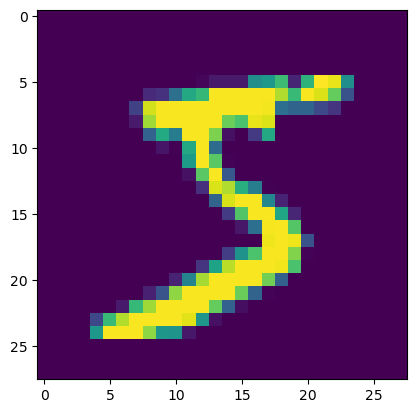

In [15]:
X = X_train[[0]]
plt.imshow(X[0])

In [16]:
y = model.predict(X)
y = (y/scale).astype(int)

1/1 [==============================] - 0s 52ms/step


-21795 61762 6381.486686390533


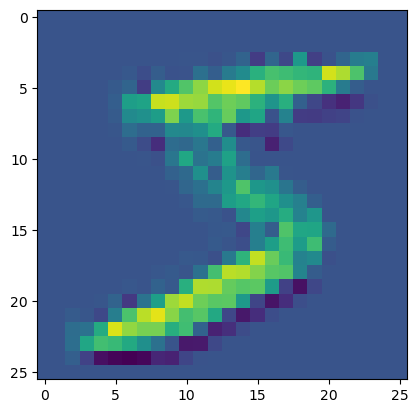

In [17]:
A = y[0,:,:,0]
print(A.min(), A.max(), A.mean())
plt.imshow(A)

-22820.0 60394.0 6414.358


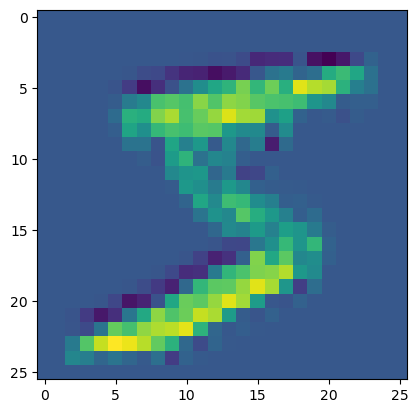

In [18]:
B = (convolve2d(X[0,:,:,0], weights[0,:,:,0], mode="valid")+biases[0])
print(B.min(), B.max(), B.mean())
plt.imshow(B)

In [19]:
((A-B)**2).mean()**.5

10053.760971256466

In [20]:
in_json = {
    "in": X.astype(int).flatten().tolist(),
    "weights": weights.flatten().tolist(),
    "bias": biases.flatten().tolist(),
}

In [21]:
out_json = {
    "scale": scale,
    "out": y.flatten().tolist(),
}

In [22]:
import json

In [23]:
with open("conv2D_input.json", "w") as f:
    json.dump(in_json, f)

In [24]:
with open("conv2D_output.json", "w") as f:
    json.dump(out_json, f)

In [25]:
inputs = Input(shape=(28,28,1))
x = Conv2D(4, 3, 2, bias_initializer='random_normal')(inputs)
model = Model(inputs, x)

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 4)         40        
                                                                 
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter._experimental_disable_per_channel = True
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpn89q_t0z/assets


INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpn89q_t0z/assets
/Users/sty/miniforge3/envs/tf-cpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-08 20:14:49.952022: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-08 20:14:49.952038: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-08 20:14:49.952150: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmpn89q_t0z
2022-12-08 20:14:49.952583: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-08 20:14:49.952594: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info 

tf.Tensor(
[[[[  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]]

  [[  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]]

  [[  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]]

  [[  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   [  0.]
   

fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [28]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

'''
This gives a list of dictionaries. 
'''
tensor_details = tflite_interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization'][0]
    zero_points = dict['quantization'][1]
    tensor = tflite_interpreter.tensor(i)()

    #print(i, type, tensor_name, scales.shape, zero_points.shape, tensor.shape)
    print(dict)
    if "Conv2D" in tensor_name:
        weights = tensor
        scale = scales
        print(tensor)
    if "Bias" in tensor_name:
        biases = tensor
        print(tensor)

== Input details ==
name: serving_default_input_2:0
shape: [ 1 28 28  1]
type: <class 'numpy.int8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 13 13  4]
type: <class 'numpy.int8'>
{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, -128), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'model_1/conv2d_1/BiasAdd/ReadVariableOp', 'index': 1, 'shape': array([4], dtype=int32), 'shape_signature': array([4], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0027720187790691853, 0), 'quantization_parameters': {'scales': array([0.00277202], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
[-10 -14  -6   3]
{'name': 'model_1

In [29]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

'''
This gives a list of dictionaries. 
'''
tensor_details = tflite_interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization'][0]
    zero_points = dict['quantization'][1]
    tensor = tflite_interpreter.tensor(i)()

    #print(i, type, tensor_name, scales.shape, zero_points.shape, tensor.shape)
    print(dict)
    if "Conv2D" in tensor_name:
        weights = tensor
        scale = scales
        print(tensor)
    if "Bias" in tensor_name:
        biases = tensor
        print(tensor)

== Input details ==
name: serving_default_input_2:0
shape: [ 1 28 28  1]
type: <class 'numpy.int8'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 13 13  4]
type: <class 'numpy.int8'>
{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (1.0, -128), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'model_1/conv2d_1/BiasAdd/ReadVariableOp', 'index': 1, 'shape': array([4], dtype=int32), 'shape_signature': array([4], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0027720187790691853, 0), 'quantization_parameters': {'scales': array([0.00277202], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
[-10 -14  -6   3]
{'name': 'model_1

In [30]:
(np.rollaxis(weights, 0,4)*scale)

array([[[[-0.18018122,  0.2356216 , -0.24393765, -0.2217615 ]],

        [[-0.3104661 ,  0.10810873, -0.3243262 ,  0.11642479]],

        [[ 0.24948169, -0.32987023, -0.29106197, -0.26056977]]],


       [[[ 0.19681333, -0.3243262 , -0.14968901,  0.06098441]],

        [[ 0.16077709, -0.00554404, -0.24393765, -0.0443523 ]],

        [[-0.09424864, -0.17186516, -0.34373033, -0.10533671]]],


       [[[-0.18849728,  0.28551793, -0.13582892,  0.00554404]],

        [[-0.17463718, -0.06375643, -0.03049221,  0.28551793]],

        [[-0.16354911,  0.35204638,  0.02217615,  0.11365277]]]])

In [31]:
model.weights[0].numpy()

array([[[[-0.1790418 ,  0.23467743, -0.2438108 , -0.2204988 ]],

        [[-0.31095928,  0.10880041, -0.32511303,  0.11640319]],

        [[ 0.24892288, -0.32915077, -0.2924192 , -0.26126534]]],


       [[[ 0.19673735, -0.32425672, -0.15015416,  0.06109697]],

        [[ 0.16205806, -0.00420848, -0.24370712, -0.04306594]],

        [[-0.09421137, -0.17218092, -0.34267926, -0.104927  ]]],


       [[[-0.18938474,  0.28673393, -0.13650641,  0.00675964]],

        [[-0.1733179 , -0.06357726, -0.03056377,  0.28475887]],

        [[-0.16476949,  0.35204637,  0.02117482,  0.11258107]]]],
      dtype=float32)

In [32]:
biases*scale

array([-0.02772019, -0.03880826, -0.01663211,  0.00831606])

In [33]:
model.weights[1].numpy()

array([-0.02716131, -0.03873774, -0.01801004,  0.00793236], dtype=float32)

In [34]:
X = X_train[[0]]
X.shape

(1, 28, 28, 1)

In [35]:
y = model.predict(X)
y = (y/scale).astype(int)
y

1/1 [==============================] - 0s 26ms/step


array([[[[     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2]],

        [[     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [     -9,     -13,      -6,       2],
         [ 

In [36]:
in_json = {
    "in": X.astype(int).flatten().tolist(),
    "weights": weights.flatten().tolist(),
    "bias": biases.flatten().tolist(),
}

In [37]:
out_json = {
    "scale": scale,
    "out": y.flatten().tolist()
}

In [38]:
with open("conv2D_stride_input.json", "w") as f:
    json.dump(in_json, f)

In [39]:
with open("conv2D_stride_output.json", "w") as f:
    json.dump(out_json, f)